In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
btc = yf.download(tickers='BTC-USD', period = '1mo', interval = '1h')

[*********************100%***********************]  1 of 1 completed


In [3]:
btc.reset_index(inplace=True)

In [4]:
btc

,index,Open,High,Low,Close,Adj Close,Volume
0,2021-03-04 23:00:00+00:00,48326.519531,48698.652344,48186.472656,48564.972656,48564.972656,0
1,2021-03-05 00:00:00+00:00,48527.031250,48527.031250,46693.558594,46813.218750,46813.218750,978391040
2,2021-03-05 01:00:00+00:00,46813.968750,46973.476562,46552.128906,46757.203125,46757.203125,687693824
3,2021-03-05 02:00:00+00:00,46751.125000,47179.156250,46589.441406,47173.671875,47173.671875,675340288
4,2021-03-05 03:00:00+00:00,47181.925781,47352.863281,46998.781250,47342.878906,47342.878906,0
...,...,...,...,...,...,...,...
740,2021-04-04 20:00:00+01:00,58534.472656,58603.355469,58312.085938,58411.789062,58411.789062,143896576
741,2021-04-04 21:00:00+01:00,58415.941406,58552.699219,58364.218750,58552.515625,58552.515625,227516416
742,2021-04-04 22:00:00+01:00,58541.210938,58617.304688,58492.320312,58556.246094,58556.246094,83521536
743,2021-04-04 23:00:00+01:00,58565.191406,58634.882812,58401.601562,58623.089844,58623.089844,64913408


In [5]:
btc.rename(columns = {'index':'Date'}, inplace = True)

In [6]:
btc['Date'] = pd.to_datetime(btc['Date'])

In [7]:
btc.set_index('Date')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-04 23:00:00+00:00,48326.519531,48698.652344,48186.472656,48564.972656,48564.972656,0
2021-03-05 00:00:00+00:00,48527.031250,48527.031250,46693.558594,46813.218750,46813.218750,978391040
2021-03-05 01:00:00+00:00,46813.968750,46973.476562,46552.128906,46757.203125,46757.203125,687693824
2021-03-05 02:00:00+00:00,46751.125000,47179.156250,46589.441406,47173.671875,47173.671875,675340288
2021-03-05 03:00:00+00:00,47181.925781,47352.863281,46998.781250,47342.878906,47342.878906,0
...,...,...,...,...,...,...
2021-04-04 20:00:00+01:00,58534.472656,58603.355469,58312.085938,58411.789062,58411.789062,143896576
2021-04-04 21:00:00+01:00,58415.941406,58552.699219,58364.218750,58552.515625,58552.515625,227516416
2021-04-04 22:00:00+01:00,58541.210938,58617.304688,58492.320312,58556.246094,58556.246094,83521536


In [8]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/backtesting/_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [9]:
# Function to return the SMA
def SMA(values, n):
    return pd.Series(values).rolling(n).mean()
class SmaCross(Strategy):
    # Placeholder for calculations
    ma_short = 10
    ma_long = 20
    df = btc
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.df.Close.to_numpy(), self.ma_short)
        self.sma2 = self.I(SMA, self.df.Close.to_numpy(), self.ma_long)
    
    def next(self):
        # If sma1 crosses above sma2 buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()
        # Else, if sma1 crosses below sma2 sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()

In [10]:
# reminder that we use this Backtest class
bt = Backtest(data=btc, strategy=SmaCross, cash=100000, commission=.002)
# evaluate all possible combinations
stats, heatmap = bt.optimize(
    ma_short=range(1, 84, 2),
    ma_long=range(10, 360, 2),
    constraint=lambda p: p.ma_short < p.ma_long,
    maximize='Equity Final [$]',
    return_heatmap=True)
# check the top 10 returns
heatmap.sort_values(ascending=False).iloc[:10]

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  
/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/backtesting/backtesting.py:1472: UserWarning: Searching for best of 6647 configurations.
  output = _optimize_grid()


ma_short  ma_long
11        46         118799.347125
53        54         116541.465352
37        38         115977.675523
11        44         113484.659867
19        42         112999.760172
15        44         112468.432391
1         42         111881.427086
7         44         111771.390648
17        40         111677.418227
45        46         111585.579789
Name: Equity Final [$], dtype: float64

<AxesSubplot:xlabel='ma_long', ylabel='ma_short'>

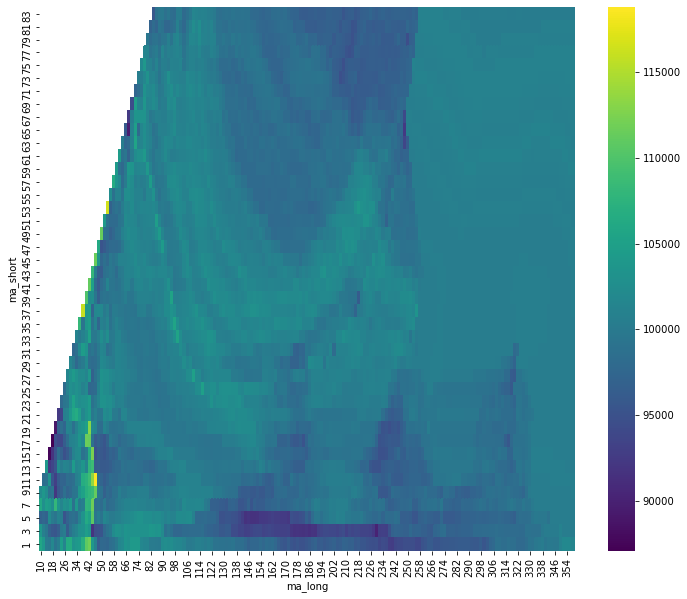

In [11]:
# group 
hm = heatmap.groupby(['ma_short', 'ma_long']).mean().unstack()
#plot heatmap
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(hm[::-1], cmap='viridis')

In [ ]:
# After running the optimizer several times, it appears that because of the votality behind BTC
# the SMA should be optimized every so often to ensure the best results

In [14]:
from backtesting import Strategy
from backtesting.lib import crossover
class SmaCross_3_66(Strategy):
    # Define the two MA lags as *class variables*
    ma_short = 3
    ma_long = 66
    df = btc
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.df.Close.to_numpy(), self.ma_short)
        self.sma2 = self.I(SMA, self.df.Close.to_numpy(), self.ma_long)
    
    def next(self):
        # If sma1 crosses above sma2 buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()
# Else, if sma1 crosses below sma2 sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()

# run the backtest
bt = Backtest(data=btc, strategy=SmaCross_3_66, cash=100000, commission=.002)
bt.run()
# plot the trades
bt.plot()

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.


In [16]:
bt = Backtest(data=btc, strategy=SmaCross_3_66, cash=100000, commission=.002)
bt.run()

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  """Entry point for launching an IPython kernel.


Start                                       0
End                                       744
Duration                                  744
Exposure Time [%]                     37.8523
Equity Final [$]                       103453
Equity Peak [$]                        104968
Return [%]                            3.45331
Buy & Hold Return [%]                 20.7108
Return (Ann.) [%]                         NaN
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                    -3.59415
Avg. Drawdown [%]                    -1.17739
Max. Drawdown Duration                    205
Avg. Drawdown Duration                35.5833
# Trades                                    4
Win Rate [%]                               50
Best Trade [%]                        9.25663
Worst Trade [%]                        -2.997
Avg. Trade [%]                    

In [ ]:
from backtesting import Strategy
from backtesting.lib import crossover
class SmaCross_27_50(Strategy):
    # Define the two MA lags as *class variables*
    ma_short = 27
    ma_long = 50
    df = df
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.df.Close.to_numpy(), self.ma_short)
        self.sma2 = self.I(SMA, self.df.Close.to_numpy(), self.ma_long)
    
    def next(self):
        # If sma1 crosses above sma2 buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()
# Else, if sma1 crosses below sma2 sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()

# run the backtest
bt = Backtest(data=df, strategy=SmaCross_27_50, cash=100000, commission=.002)
bt.run()
# plot the trades
bt.plot()

In [ ]:
bt = Backtest(data=df, strategy=SmaCross_27_50, cash=100000, commission=.002)
bt.run()

In [ ]:
# Results seem to vary quite frequently for SMA, so let's move to EMA to see what timeframe we should be trading off of
# EMA will most likely be more stable because it's the exponential, so it will be placing higher weight on more frequent changes
# Therefore, it's less likely to be reactive towards ebbs and flows in market that could affect ema short and long ranges

In [18]:
# Function to return the EMA
def EMA(values, n):
    return pd.Series.ewm(values, span=n).mean()
class EmaCross(Strategy):
    ma_short = 10
    ma_long = 20
    df = btc
    
    def init(self):
        # Precompute the two moving averages
        self.ema1 = self.I(EMA, self.df.Close, self.ma_short)
        self.ema2 = self.I(EMA, self.df.Close, self.ma_long)
    
    def next(self):
        # If ema1 crosses above ema2 buy the asset
        if crossover(self.ema1, self.ema2):
            self.buy()
        # Else, if ema1 crosses below ema2 sell the asset
        elif crossover(self.ema2, self.ema1):
            self.position.close()

In [23]:
# reminder that we use this Backtest class
bt = Backtest(data=btc, strategy=EmaCross, cash=100000, commission=.002)
# evaluate all possible combinations
stats, heatmap = bt.optimize(
    ma_short=range(1, 12, 1),
    ma_long=range(6, 60, 1),
    constraint=lambda p: p.ma_short < p.ma_long,
    maximize='Equity Final [$]',
    return_heatmap=True)
# check the top 10 returns
heatmap.sort_values(ascending=False).iloc[:10]

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  
/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/backtesting/backtesting.py:1472: UserWarning: Searching for best of 573 configurations.
  output = _optimize_grid()


ma_short  ma_long
6         52         126177.945953
          53         125203.305250
          59         125040.906062
7         51         124591.945500
6         54         124126.359937
          58         123821.914656
          57         123821.914656
          56         123821.914656
7         52         123749.991516
6         55         123559.750750
Name: Equity Final [$], dtype: float64

<AxesSubplot:xlabel='ma_long', ylabel='ma_short'>

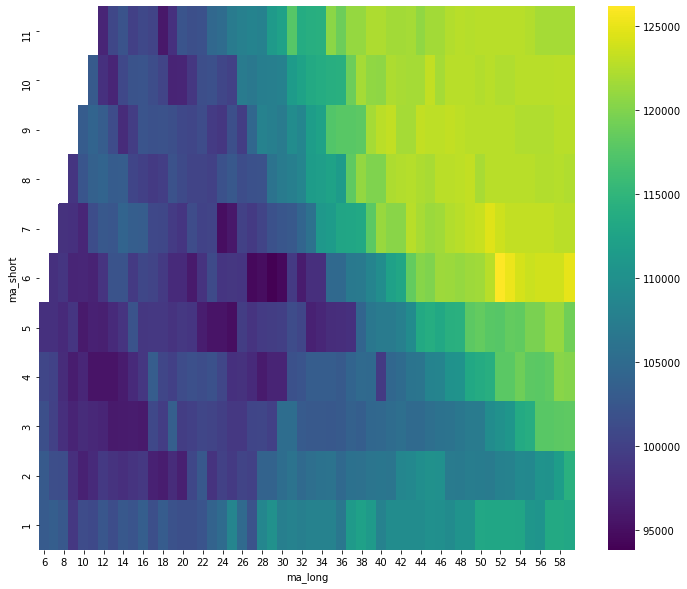

In [24]:
# group 
hm = heatmap.groupby(['ma_short', 'ma_long']).mean().unstack()
#plot heatmap
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(hm[::-1], cmap='viridis')

In [25]:
from backtesting import Strategy
from backtesting.lib import crossover
class EmaCross_6_52(Strategy):
    # Define the two MA lags as *class variables*
    ma_short = 6
    ma_long = 52
    df = btc
    
    def init(self):
        # Precompute the two moving averages
        self.ema1 = self.I(EMA, self.df.Close, self.ma_short)
        self.ema2 = self.I(EMA, self.df.Close, self.ma_long)
    
    def next(self):
        # If sma1 crosses above sma2 buy the asset
        if crossover(self.ema1, self.ema2):
            self.buy()
# Else, if sma1 crosses below sma2 sell the asset
        elif crossover(self.ema2, self.ema1):
            self.position.close()

# run the backtest
bt = Backtest(data=btc, strategy=EmaCross_6_52, cash=100000, commission=.002)
bt.run()
# plot the trades
bt.plot()

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.


In [27]:
# run the backtest
bt = Backtest(data=btc, strategy=EmaCross_6_52, cash=100000, commission=.002)
bt.run()

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  


Start                                       0
End                                       744
Duration                                  744
Exposure Time [%]                     69.1275
Equity Final [$]                       126178
Equity Peak [$]                        128492
Return [%]                            26.1779
Buy & Hold Return [%]                 20.7108
Return (Ann.) [%]                         NaN
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                    -8.68985
Avg. Drawdown [%]                    -1.72723
Max. Drawdown Duration                    397
Avg. Drawdown Duration                  28.48
# Trades                                    6
Win Rate [%]                          83.3333
Best Trade [%]                        20.6322
Worst Trade [%]                      -3.95479
Avg. Trade [%]                    

In [ ]:
SMA_3 = pd.Series(btc.Close).rolling(3).mean()

In [ ]:
SMA_3

In [ ]:
SMA_66 = pd.Series(btc.Close).rolling(66).mean()

In [ ]:
SMA_66

In [ ]:
btc

In [ ]:
btc_close = btc[['Date', 'Close']]
btc_close

In [ ]:
SMA_27 = pd.Series(btc.Close).rolling(27).mean()
SMA_50 = pd.Series(btc.Close).rolling(50).mean()

In [ ]:
btc_close['SMA_27'] = SMA_27
btc_close['SMA_50'] = SMA_50

In [ ]:
btc_close['SMA_3'] = SMA_3
btc_close['SMA_66'] = SMA_66

In [ ]:
btc_close

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(btc_close['Date'], btc_close['Close'], label='Closing Price')
plt.plot(btc_close['Date'], btc_close['SMA_3'], label='SMA_3')
plt.plot(btc_close['Date'], btc_close['SMA_66'], label='SMA_66')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(btc_close['Date'], btc_close['Close'], label='Closing Price')
plt.plot(btc_close['Date'], btc_close['SMA_27'], label='SMA_27')
plt.plot(btc_close['Date'], btc_close['SMA_50'], label='SMA_50')
plt.legend()
plt.show()

In [ ]:
delta = btc['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down

In [ ]:
rs

In [ ]:
btc_close['RSI'] = 100 - (100/(1 + rs))

btc_close

In [ ]:
exp1 = btc[['Date', 'Close']].ewm(span=12, adjust=False).mean()
exp2 = btc[['Date', 'Close']].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2

In [ ]:
macd

In [ ]:
exp3 = macd.ewm(span=9, adjust=False).mean()
exp3

In [ ]:
btc_close['MACD'] = macd
btc_close['Signal'] = exp3

In [ ]:
btc_close.head(60)

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(btc_close['Date'], btc_close['MACD'], label='MACD')
plt.plot(btc_close['Date'], btc_close['Signal'], label='Signal')
plt.legend()
plt.show()

In [ ]:
btc_close['Trend'] = 0
for index, row in btc_close.iterrows():
    try:
        prev_signal = btc_close.at[index - 1, 'Signal']
        current_signal = btc_close.at[index, 'Signal']
        if index == 0 or index == 1:
            continue
        else:
            if prev_signal > current_signal:
                btc_close.at[index, 'Trend'] = -1
            else:
                btc_close.at[index, 'Trend'] = 1
    except:
        pass

In [ ]:
btc_close.head(50)

In [ ]:
btc_close['Buy/Sell'] = ""
for index, row in btc_close.iterrows():
    try:
        current_trend = btc_close.at[index, 'Trend']
        prev_trend = btc_close.at[index - 1, 'Trend']
        #SMA_3 = btc_close.at[index, 'SMA_3']
        #SMA_66 = btc_close.at[index, 'SMA_66']
        #isNaN_prev = np.isnan(prev_trend)
        #isNaN_current = np.isnan(current_trend)
        if prev_trend == 0 or current_trend == 0:
            pass
        elif prev_trend != current_trend:
            print("Trend different")
            print(f"{prev_trend} and {current_trend}")
            if prev_trend == -1:
                btc_close.at[index, 'Buy/Sell'] = 'Buy'
            else:
                btc_close.at[index, 'Buy/Sell'] = 'Sell'
        else:
            continue
    except:
        pass

In [ ]:
btc_close['Cross'] = ""
for index, row in btc_close.iterrows():
    try:
        #current_trend = btc_close.at[index, 'Trend']
        #prev_trend = btc_close.at[index - 1, 'Trend']
        curr_SMA_3 = btc_close.at[index, 'SMA_3']
        curr_SMA_66 = btc_close.at[index, 'SMA_66']
        prev_SMA_3 = btc_close.at[index - 1, 'SMA_3']
        prev_SMA_66 = btc_close.at[index - 1, 'SMA_66']
        curr_isNaN_3 = np.isnan(curr_SMA_3)
        curr_isNaN_66 = np.isnan(curr_SMA_66)
        prev_isNaN_3 = np.isnan(prev_SMA_3)
        prev_isNaN_66 = np.isnan(prev_SMA_66)
        if curr_isNaN_3 == True or curr_isNaN_66 == True or prev_isNaN_3 == True or prev_isNaN_66 == True:
            pass
        else:
            if prev_SMA_3 < prev_SMA_66 and curr_SMA_3 > curr_SMA_66:
                btc_close.at[index, 'Cross'] = 'Bull Cross'
            elif prev_SMA_3 > prev_SMA_66 and curr_SMA_3 < curr_SMA_66:
                btc_close.at[index, 'Cross'] = 'Bear Cross'
            else:
                continue
    except:
        pass

In [ ]:
btc_close.head(60)

In [ ]:
btc_close.head(50)

In [ ]:
rolling_mean = btc_close['Close'].rolling(3).mean()
rolling_std = btc_close['Close'].rolling(3).std()

In [ ]:
btc_close['Bollinger High'] = rolling_mean + (rolling_std * 1)
btc_close['Bollinger Low'] = rolling_mean - (rolling_std * 1)     

In [ ]:
btc_close.head(50)

In [ ]:
btc_close.loc[btc_close['Buy/Sell'] != ''].head(20)

In [ ]:
btc_close.loc[(btc_close['Buy/Sell'] == 'Buy') & (btc_close['SMA_3'] >= btc_close['SMA_66'])]